<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C2/C2.html"><img src="../data/C2_nav.png" width="100"  style="float:right;" alt="C1"></a>
<h1>STFT: Inverse</h1> 
</div>

<br/>

<p>
In this notebook, we introduce the inverse DFT and then show how a signal can be recovered from its STFT under relatively mild conditions on the windowing process. In most parts, we closely follow Section Section 2.4.2 and Section 8.1.2.1 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>.
</p> 

## Inverse DFT


Given a vector $x\in \mathbb{C}^N$ of length $N\in\mathbb{N}$, the [**discrete Fourier transform**](../C2/C2_DFT-FFT.html) is defined by the matrix&ndash;vector product

$$
X = \mathrm{DFT}_N \cdot x
$$

with the DFT matrix $\mathrm{DFT}_N \in \mathbb{C}^{N\times N}$ given by 

$$
\mathrm{DFT}_N(n, k) = \mathrm{exp}(-2 \pi i k n / N)
$$

for $n\in[0:N-1]$ and $k\in[0:N-1]$. The DFT is **invertible** in the sense that the vector $x$ can be recovered from its spectral vector $X$. The inverse DFT is again specified by a matrix&ndash;vector product

$$
x = \mathrm{DFT}_N^{-1} \cdot X, 
$$

where $\mathrm{DFT}_N^{-1}$ denotes the **inverse** of the DFT matrix $\mathrm{DFT}_N$. It is a well-known fact that this inverse is given by 

$$
\mathrm{DFT}_N^{-1}(n, k) = \frac{1}{N}\mathrm{exp}(2 \pi i k n / N)
$$

for $n\in[0:N-1]$ and $k\in[0:N-1]$. In other words, the inverse essentially coincides with the DFT matrix up to some normalizing factor and complex conjugation. In the following code cell, we generate the DFT matrix and its inverse. Furthermore, we show that the two matrices are indeed inverse to each other (up to some numerical issues
due to rounding in floating point arithmetic). To this end, we measure the entry-wise difference between $\mathrm{DFT}_N \cdot \mathrm{DFT}_N^{-1}$ and the the identity matrix $I_N\in \mathbb{R}^{N\times N}$ as well as between  $\mathrm{DFT}_N^{-1} \cdot\mathrm{DFT}_N$ and $I_N$.

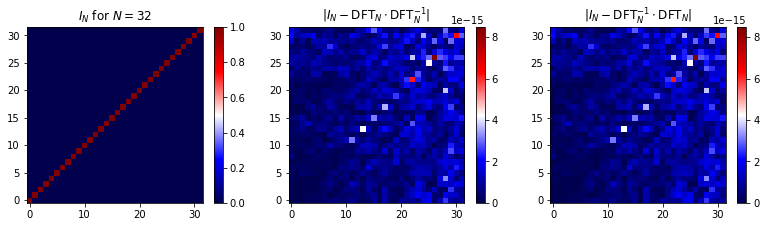

In [1]:
import os
import numpy as np
import scipy.signal
import librosa
from numba import jit
from matplotlib import pyplot as plt

import sys
sys.path.append('..')
import LibFMP.C2

%matplotlib inline

@jit(nopython=True)
def generate_matrix_dft_inv(N, K):
    """Generates an IDFT (inverse discete Fourier transfrom) matrix

    Notebook: C2/C2_STFT-Inverse.ipynb

    Args:
        N: Number of samples
        K: Number of frequency bins

    Returns:
        dft: The IDFT matrix
    """
    dft = np.zeros((K, N), dtype=np.complex128)
    for n in range(N):
        for k in range(K):
            dft[k, n] = np.exp(2j * np.pi * k * n / N) / N
    return dft

N = 32
dft_mat = LibFMP.C2.generate_matrix_dft(N, N)
dft_mat_inv = generate_matrix_dft_inv(N, N)

I = np.eye(N)
A =  np.dot(dft_mat, dft_mat_inv)
B =  np.dot(dft_mat_inv, dft_mat)

plt.figure(figsize=(11, 3))

plt.subplot(1, 3, 1)
plt.title(r'$I_N$ for $N = %d$'%N)
plt.imshow(I, origin='lower', cmap='seismic', aspect='equal')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title(r'$|I_N - \mathrm{DFT}_N \cdot \mathrm{DFT}_N^{-1}|$')
plt.imshow(np.abs(I-A), origin='lower', cmap='seismic', aspect='equal')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title(r'$|I_N - \mathrm{DFT}_N^{-1} \cdot \mathrm{DFT}_N|$')
plt.imshow(np.abs(I-B), origin='lower', cmap='seismic', aspect='equal')
plt.colorbar();

plt.tight_layout()

Recall that the DFT can be computed efficiently using the [FFT algorithm](../C2/C2_DFT-FFT.html). Basically the same algorithm can be also applied to compute the inverse DFT. In the following, we will use the implementations `numpy.fft.fft` and `numpy.fft.ifft`.

## Inverse STFT

Next, we discuss the problem of inverting the discrete [short-time Fourier transform](../C2/C2_STFT-Basic.html) (STFT). As usual, let  $x:\mathbb{Z}\to\mathbb{R}$ be a discrete-time signal and $\mathcal{X}$ its STFT. Furthermore, let $w:[0:N-1]\to\mathbb{R}$ denote the underlying real-valued discrete window function of length $N\in\mathbb{N}$ and $H\in\mathbb{N}$ the hop size parameter. For notational convenience, we extend the window function to $w:\mathbb{Z}\to\mathbb{R}$ using zero padding. Let $x_n:\mathbb{Z}\to\mathbb{R}$ be the windowed signal defined by

\begin{equation}
   x_n(r):=x(r+nH)w(r)
\end{equation}

for $r\in\mathbb{Z}$. Then, the STFT coefficients $\mathcal{X}(n,k)$ for $k\in[0:N-1]$ are obtained via 

$$
  (\mathcal{X}(n,0),\ldots, \mathcal{X}(n,N-1))^\top = 
  \mathrm{DFT}_N \cdot (x_n(0),\ldots, x_n(N-1))^\top.
$$

Since $\mathrm{DFT}_N$ is an invertible matrix, we can reconstruct the windowed signal $x_n$ from the STFT by 

$$
   (x_n(0),\ldots x_n(N-1))^\top
   = \mathrm{DFT}_N^{-1} \cdot (\mathcal{X}(n,0),\ldots, \mathcal{X}(n,N-1))^\top
$$

and $x_n(r)=0$ for $r\in\mathbb{Z}\setminus[0,N-1]$. To obtain the samples $x(r)$ of the original signal, one has to reverse the windowing process. We now show that this is possible under relatively mild conditions on the windowing process. Let us consider the superposition over all suitably shifted versions of windowed sections of the signal: 

$$
   \sum_{n\in\mathbb{Z}} x_n(r-nH)  
   = \sum_{n\in\mathbb{Z}} x(r-nH+nH)w(r-nH)
   = x(r)\sum_{n\in\mathbb{Z}} w(r-nH).   
$$

Therefore, one can recover the samples $x(r)$ via

$$
   x(r) = \frac{\sum_{n\in\mathbb{Z}} x_n(r-nH)}{\sum_{n\in\mathbb{Z}} w(r-nH)}
$$

as long as the condition 

$$
   \sum_{n\in\mathbb{Z}} w(r-nH)\not= 0
$$

is satisfied for $r\in\mathbb{Z}$. This overall approach is based on the so-called **overlap&ndash;add technique**, where the overlapping reconstructed windowed sections are simply overlaid and added up (and then normalized to compensate for the windowing).

## Partition of Unity

It is not hard to find window functions along with hop sizes that satisfy the above condition. For example, when the window function $w:[0:N-1]\to\mathbb{R}$ is strictly positive and the hop size is smaller than or equal to the window length, then the sum over the time-shifted windows is always positive. Often, one chooses a window function and a hop size such that the stronger condition 

$$
   \sum_{n\in\mathbb{Z}} w(r-nH) = 1
$$

for all $r\in\mathbb{Z}$ is fulfilled. In this case, one also says that the time-shifted window functions define a **partition of unity** of the discrete time axis $\mathbb{Z}$. For example, one obtains a partition of unity when using the **squared sinusoidal** as window $w:\mathbb{Z}\to\mathbb{R}$ defined by

\begin{equation}
   w(r):= \left\{ \begin{array}{cl}
                 \sin(\pi r/N)^2 &  \,\mbox{if}\,\,\, r\in[0:N-1],\\
                 0 & \,\mbox{otherwise} ,
                 \end{array} \right.
\end{equation}

and a hop size of $H=N/2$. Note that  the property of being a partition of unity not only depends on the window function itself but also on the hop size parameter. The following figure shows various window functions of length $N$ and their time-shifted versions using a hop size  $H$. The sum of the shown time-shifted versions is indicated by the thick red curve.

<!--<img src="../data/C8/FMP_C8_F07_text.png" width="450px" align="middle" alt="FMP_C8_F07_text">-->

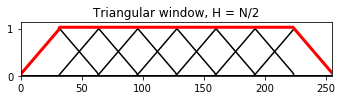

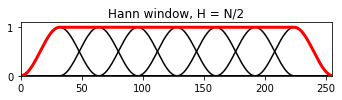

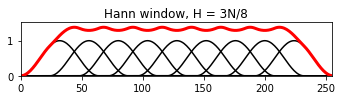

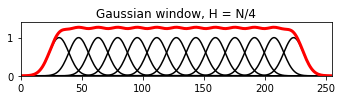

In [2]:
def plot_sum_window(w, H, L, title='', figsize=(5, 1.5)):
    N = len(w)
    M = np.floor((L - N) / H).astype(int) + 1
    w_sum = np.zeros(L)
    plt.figure(figsize=figsize)
    for m in range(M):
        w_shifted = np.zeros(L)
        w_shifted[m * H:m * H + N] = w
        plt.plot(w_shifted, 'k')
        w_sum = w_sum + w_shifted
    plt.plot(w_sum, 'r', linewidth=3)
    plt.xlim([0, L-1])
    plt.ylim([0, 1.1*np.max(w_sum)])
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return w_sum
     
L = 256
N = 64

H = N//2
w_type = 'triang'
w = scipy.signal.get_window(w_type, N)
plot_sum_window(w, H, L, title='Triangular window, H = N/2');

H = N//2
w_type = 'hann'
w = scipy.signal.get_window(w_type, N)
plot_sum_window(w, H, L, title='Hann window, H = N/2');

H = 3*N//8
w_type = 'hann'
w = scipy.signal.get_window(w_type, N)
plot_sum_window(w, H, L, title='Hann window, H = 3N/8');

H = N//4
w = scipy.signal.gaussian(N, std=8)
plot_sum_window(w, H, L, title='Gaussian window, H = N/4');

## Basic Implementation of STFT and Inverse STFT

In the following code cell, we provide a pair of implementations for the STFT and its inverse. Here are some notes one needs to keep in mind that are of practical relevance:

* To avoid small imaginary values in the inverse DFT (due to floating point arithmetic), it may be beneficial to only keep the real parts of the reconstructed windowed signals.
* After applying the inverse DFT, one needs to compensate for the windowing. Rather than doing this on a frame-based level (i.e., for each windowed section individually), one should do the compensation **globally** by accumulate all windowed signals as well all shifted windows separately. The reason why the global compensation is possible lies in the **linearity** of the DFT. Furthermore, in the compensation, one needs to avoid division by zero. 
* In the case that the shifted windows (for a given hopsize) form a partition of unity, no compensation needs to be performed. 
* In the case that [padding](../C2/C2_STFT-Padding.html) is applied in the STFT computation, one has to take this into consideration when computing the inverse STFT.

<div class="alert alert-block alert-warning">
<strong>Important note:</strong> In practice, one often uses a different reconstruction formula as the one used in the following implementation. This issues will be discuss in the next paragraph and in the <a href="../C8/C8S1_SignalReconstruction.html">FMP notebook on signal reconstruction</a>.
</div>

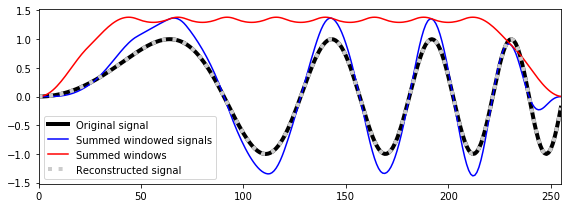

In [3]:
def istft_basic(X, w, H, L):
    """Compute the inverse of the basic discrete short-time Fourier transform (ISTFT)

    Notebook: C2/C2_STFT-Inverse.ipynb

    Args:
        X: The discrete short-time Fourier transform
        w: Window function
        H: Hopsize
        L: Length of time signal

    Returns:
        x: Time signal
    """
    N = len(w)
    M = X.shape[1]
    x_win_sum = np.zeros(L)
    w_sum = np.zeros(L)
    for m in range(M):
        x_win = np.fft.ifft(X[:,m])
        # Avoid imaginary values (due to floating point arithmetic)
        x_win = np.real(x_win)
        x_win_sum[m * H:m * H + N] = x_win_sum[m * H:m * H + N] + x_win
        w_shifted = np.zeros(L)
        w_shifted[m * H:m * H + N] = w
        w_sum = w_sum + w_shifted 
    # Avoid division by zero    
    w_sum[w_sum==0] = np.finfo(np.float32).eps
    x_rec = x_win_sum / w_sum
    return x_rec, x_win_sum, w_sum

L = 256
t = np.arange(L) / L
omega = 4
x = np.sin(2 * np.pi * omega * t * t)

N = 64
H = 3 * N // 8
w_type = 'hann'
w = scipy.signal.get_window(w_type, N)
X = LibFMP.C2.stft_basic(x, w=w, H=H)
x_rec, x_win_sum, w_sum = istft_basic(X, w=w, H=H, L=L)

plt.figure(figsize=(8, 3))
plt.plot(x, color=[0, 0, 0], linewidth=4, label='Original signal')
plt.plot(x_win_sum, 'b', label='Summed windowed signals')
plt.plot(w_sum, 'r', label='Summed windows')
plt.plot(x_rec, color=[0.8, 0.8, 0.8], linestyle=':', linewidth=4, label='Reconstructed signal')
plt.xlim([0,L-1])
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## Alternative Compensation for Windowing

We have seen above that the samples $x(r)$ can be recovered from a signal's windowed sections via the formula 

$$
   x(r) = \frac{\sum_{n\in\mathbb{Z}} x_n(r-nH)}{\sum_{n\in\mathbb{Z}} w(r-nH)}
$$

in the case that the denominator is nonzero for $r\in\mathbb{Z}$. In practice, when reconstructing a time-domain signal from an STFT, one often has to deal with unwanted or deliberate modification in the STFT domain. This topic will be covered in the [FMP notebook on signal reconstruction](../C8/C8S1_SignalReconstruction.ipynb). In view of such modifications, it turns out that the following formula yields a better reconstruction of the samples $x(r)$:

$$
   x(r) = \frac{\sum_{n\in\mathbb{Z}} w(r-nH)x_n(r-nH)}{\sum_{n\in\mathbb{Z}} w(r-nH)^2},
$$

where one again assumes that the denominator is nonzero for $r\in\mathbb{Z}$. In the case that there are no modifications in the STFT domain, both reconstruction formulas yield exactly the original samples. The second strategy is also used in the function `librosa.istft`.

## LibROSA Implementation 

The python package <a href="https://librosa.github.io/">LibROSA</a> offers the two functions `librosa.stft` and `librosa.istft` for computing the STFT and its inverse. In the following, we test these two functions. In particular, we want to demonstrate that it is important to compensate for possible padding, e.g., when using the centered variant of the STFT. As an example, we use the following violin sound.

<audio style="width: 320px;" src="../data/C2/FMP_C2_F05c_C4_violin.mp3" type="audio/mpeg" controls="controls"></audio>


=== Centered Case ===
stft: center=True; istft: center=True
Number of samples of x:     46656
Number of samples of x_rec: 46656
Signals x and x_inv agree: False


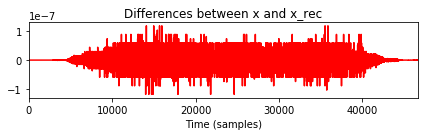

=== Non-Centered Case ===
stft: center=False; istft: center=False
Number of samples of x:     46656
Number of samples of x_rec: 46656
Signals x and x_inv agree: False


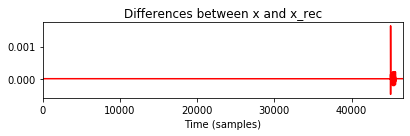

=== Centered vs. Non-Centered Case ===
stft: center=True; istft: center=False
Number of samples of x:     46656
Number of samples of x_rec: 46656
Signals x and x_inv agree: False


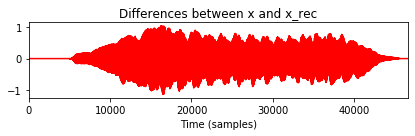

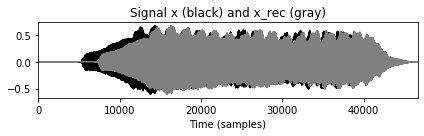

In [4]:
def print_plot(x, x_rec):
    print('Number of samples of x:    ', x.shape[0])
    print('Number of samples of x_rec:', x_rec.shape[0])
    if x.shape[0] == x_rec.shape[0]:
        print('Signals x and x_inv agree:', np.allclose(x, x_rec))
        plt.figure(figsize=(6, 2))
        plt.plot(x-x_rec, color='red')
        plt.xlim([0, x.shape[0]])
        plt.title('Differences between x and x_rec')
        plt.xlabel('Time (samples)');
        plt.tight_layout()
        plt.show()
    else:
        print('Number of samples of x and x_rec does not agree.')

fn_wav = os.path.join('..', 'data', 'C2', 'FMP_C2_F05c_C4_violin.wav')
Fs = 11025
x, Fs = librosa.load(fn_wav, sr=Fs)        
        
N = 4096
H = 2048
L = x.shape[0]

print('=== Centered Case ===')
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=True)
x_rec = librosa.istft(X, hop_length=H, win_length=N, window='hann', center=True, length=L)
print('stft: center=True; istft: center=True')
print_plot(x, x_rec)

print('=== Non-Centered Case ===')
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=False)
x_rec = librosa.istft(X, hop_length=H, win_length=N, window='hann', center=False, length=L)
print('stft: center=False; istft: center=False')
print_plot(x, x_rec)

print('=== Centered vs. Non-Centered Case ===')
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=True)
x_rec = librosa.istft(X, hop_length=H, win_length=N, window='hann', center=False, length=L)
print('stft: center=True; istft: center=False')
print_plot(x, x_rec)

plt.figure(figsize=(6, 2))
plt.plot(x, color='black')
plt.xlim([0, x.shape[0]])
plt.plot(x_rec, color='gray')
plt.title('Signal x (black) and x_rec (gray)')
plt.xlabel('Time (samples)');
plt.tight_layout()
plt.show()

## LibFMP Implementation 

We also provide an implementation of the inverse FFT, the STFT, and the inverse STFT in our library `LibFMP`. These implementations also include padding options and realize the centric view as used in the FMP notebooks (similar to `librosa`). In the following code cell, we call these `LibFMP` function.

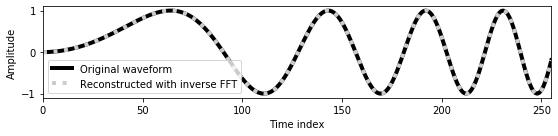

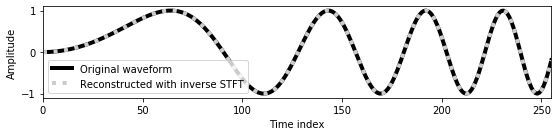

In [5]:
import sys
sys.path.append('..')
from LibFMP.C2 import fft, stft, ifft, istft

L = 256
t = np.arange(L)/L
omega = 4
x = np.sin(2 * np.pi * omega * t*t)

X = fft(x)
x_rec = np.real(ifft(X))
plt.figure(figsize=(8, 2))
plt.plot(x, color='k', linewidth=4, label='Original waveform')
plt.plot(x_rec, color=[0.8, 0.8, 0.8], linestyle=':', linewidth=4, label='Reconstructed with inverse FFT')
plt.xlim([0,L-1])
plt.xlabel('Time index')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()

N = 64
H = 3 * N // 8
w = scipy.signal.get_window('hann', N)
X_stft = stft(x, w=w, H=H)
x_stft_rec = istft(X_stft, w=w, H=H, L=L)
plt.figure(figsize=(8, 2))
plt.plot(x, color='k', linewidth=4, label='Original waveform')
plt.plot(x_stft_rec, color=[0.8, 0.8, 0.8], linestyle=':', linewidth=4, label='Reconstructed with inverse STFT')
plt.xlim([0,L-1])
plt.xlabel('Time index')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()


## Further Notes

In this notebook, we have seen that a time-domain signal can be perfectly reconstructed from an STFT under mild conditions on the window function and the hopsize parameter (one only requires $\sum_{n\in\mathbb{Z}} w(r-nH)\not= 0$ for $r\in\mathbb{Z}$). In practice, one often modifies an STFT and then tries to reconstruct a time-domain signal from the modified STFT. Such a reconstruction, however, is generally not possible and involves some unanticipated pitfalls. For a further discussion of this topic, we refer to the [FMP notebook on signal reconstruction](../C8/C8S1_SignalReconstruction.html).

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow">Frank Zalkow</a>.
</div>  

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>